<a href="https://colab.research.google.com/github/ericiortega/ids705-phishing-detection/blob/main/notebooks/1_baseline_vs_other_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ericiortega/ids705-phishing-detection/main/data/cleaning/2_cleaned_data.csv"
)
df

,sender,receiver,clean_text,urls,label
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",0,1
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,"Typo in /debian/README Hi, i've just updated f...",1,0
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,authentic viagra Mega authenticV I A G R A ...,1,1
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,"Nice talking with ya \nHey Billy, \n\nit was r...",1,1
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,or trembling; stomach cramps; trouble in sleep...,0,1
...,...,...,...,...,...
52708,SCC <Gerry.Rossi4360@kinki-kids.com>,Deficient <deficient@flax9.uwaterloo.ca>,Job: just for you. \n\n\n\nWhile we may ...,1,1
52709,Sydney Car Centre <Merrill8783@168city.com>,Gnitpick <gnitpick@flax9.uwaterloo.ca>,the reply for your request for a job place [le...,1,1
52710,Philippe Grosjean <phgrosjean@sciviews.org>,Duncan Murdoch <murdoch@stats.uwo.ca>,"Re: [R] Me again, about the horrible documenta...",1,0
52711,Bernhard Wellhöfer <Bernhard.Wellhoefer@gaia-g...,r-help@stat.math.ethz.ch,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",1,0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


🧪 Logistic (clean_text only) Accuracy: 0.9854880015175946

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      4926
           1       0.98      0.99      0.99      5617

    accuracy                           0.99     10543
   macro avg       0.99      0.99      0.99     10543
weighted avg       0.99      0.99      0.99     10543



<Figure size 600x500 with 0 Axes>

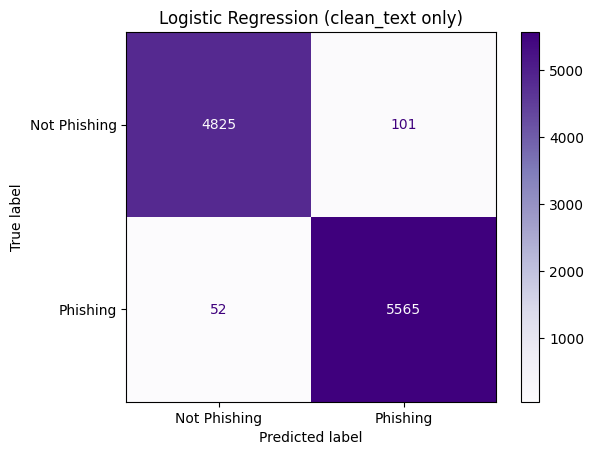

In [8]:
nltk.download("stopwords")
nltk.download("wordnet")

# === Logistic Regression: clean_text only ===
from sklearn.pipeline import Pipeline

# Step 1: Feature and label
X_text_only = df["clean_text"].fillna("unknown").astype(str)
y = df["label"]

# Step 2: Train/test split
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text_only, y, test_size=0.2, random_state=42
)

# Step 3: Build pipeline
logreg_text_only = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=1000)),
    ("clf", LogisticRegression(max_iter=2000))
])

# Step 4: Train
logreg_text_only.fit(X_train_text, y_train_text)

# Step 5: Predict and evaluate
y_pred_text = logreg_text_only.predict(X_test_text)
print("🧪 Logistic (clean_text only) Accuracy:", accuracy_score(y_test_text, y_pred_text))
print("\n📋 Classification Report:\n", classification_report(y_test_text, y_pred_text))

# Step 6: Confusion Matrix
cm_text = confusion_matrix(y_test_text, y_pred_text)
disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp_text.plot(cmap=plt.cm.Purples, values_format="d")
plt.title("Logistic Regression (clean_text only)")
plt.grid(False)
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Accuracy: 0.996585412121787

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

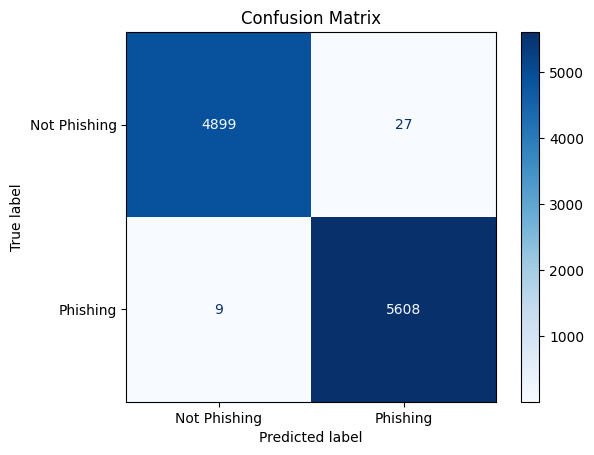

In [ ]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

# === Step 1: Prepare data ===
# Make sure all text fields are strings
for col in ["clean_text", "sender", "receiver"]:
    df[col] = df[col].fillna("unknown").replace("", "unknown").astype(str)

# === Step 2: Select features and label ===
X = df[["clean_text", "sender", "receiver", "urls"]]  # urls stays as binary
y = df["label"]

# === Step 3: Build preprocessing pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=1000), "clean_text"),
        ("sender", TfidfVectorizer(max_features=100), "sender"),
        ("receiver", TfidfVectorizer(max_features=100), "receiver"),
    ],
    remainder="passthrough"  # keep 'urls' as is (numeric)
)

# === Step 4: Build and train the model ===
model = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# === Step 5: Evaluate ===
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


# Naive

✅ Naive Bayes Accuracy: 0.9539979133074078

📋 Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      4926
           1       0.95      0.97      0.96      5617

    accuracy                           0.95     10543
   macro avg       0.95      0.95      0.95     10543
weighted avg       0.95      0.95      0.95     10543



<Figure size 600x500 with 0 Axes>

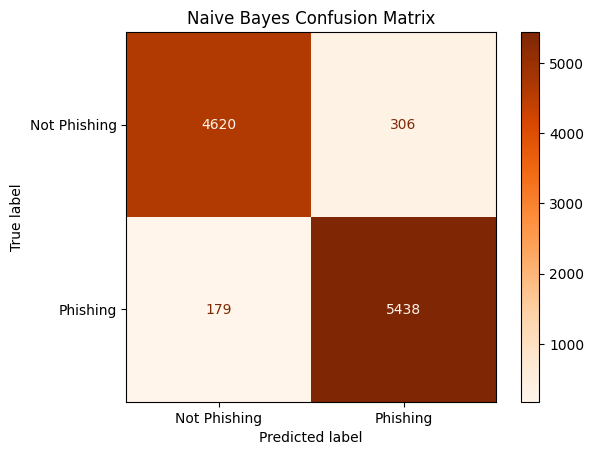

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Step 1: Make sure 'clean_text' and 'label' are ready ===
df["clean_text"] = df["clean_text"].fillna("unknown").astype(str)
X_text = df["clean_text"]
y = df["label"]

# === Step 2: Split data ===
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# === Step 3: Naive Bayes pipeline ===
nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=1000)),
    ("clf", MultinomialNB())
])

# === Step 4: Train and predict ===
nb_model.fit(X_train_text, y_train)
y_pred_nb = nb_model.predict(X_test_text)

# === Step 5: Evaluation ===
print("✅ Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\n📋 Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Oranges, values_format="d")
plt.title("Naive Bayes Confusion Matrix")
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:50:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🧪 XGBoost (clean_text only) Accuracy: 0.9930759745802903

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4926
           1       0.99      1.00      0.99      5617

    accuracy                           0.99     10543
   macro avg       0.99      0.99      0.99     10543
weighted avg       0.99      0.99      0.99     10543



<Figure size 600x500 with 0 Axes>

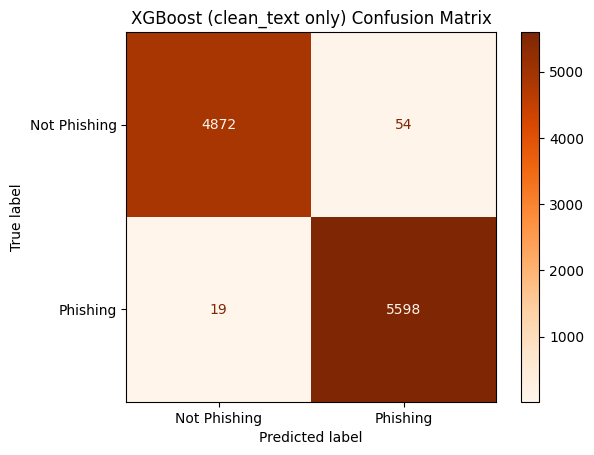

In [9]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# === Step 1: Load and prepare dataset ===

df["clean_text"] = df["clean_text"].fillna("unknown").astype(str)
y = df["label"]

# === Step 2: TF-IDF vectorization on clean_text only ===
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df["clean_text"])

# === Step 3: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# === Step 4: Train XGBoost model ===
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# === Step 5: Predict and evaluate ===
y_pred = xgb_model.predict(X_test)

print("🧪 XGBoost (clean_text only) Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Oranges, values_format="d")
plt.title("XGBoost (clean_text only) Confusion Matrix")
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:07:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Accuracy: 0.9975339087546239

📋 XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

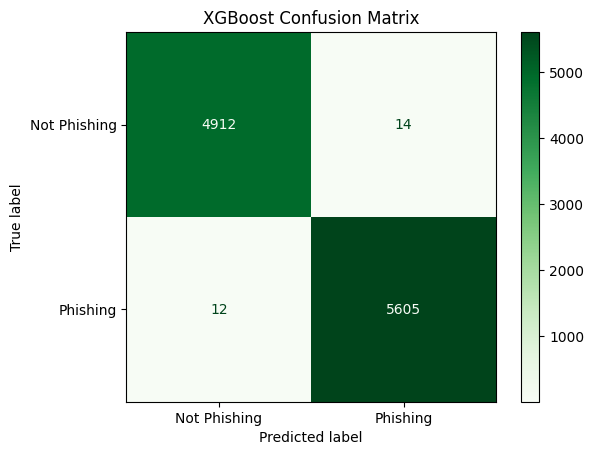

In [ ]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import pandas as pd

# === Step 1: Preprocessing ===
for col in ["clean_text", "sender", "receiver"]:
    df[col] = df[col].fillna("unknown").astype(str)

# Features & labels
X = df[["clean_text", "sender", "receiver", "urls"]]
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 2: Vectorize text columns ===
tfidf_text = TfidfVectorizer(max_features=1000)
tfidf_sender = TfidfVectorizer(max_features=100)
tfidf_receiver = TfidfVectorizer(max_features=100)

X_train_text = tfidf_text.fit_transform(X_train["clean_text"])
X_test_text = tfidf_text.transform(X_test["clean_text"])

X_train_sender = tfidf_sender.fit_transform(X_train["sender"])
X_test_sender = tfidf_sender.transform(X_test["sender"])

X_train_receiver = tfidf_receiver.fit_transform(X_train["receiver"])
X_test_receiver = tfidf_receiver.transform(X_test["receiver"])

# urls is already numeric
X_train_urls = X_train["urls"].values.reshape(-1, 1)
X_test_urls = X_test["urls"].values.reshape(-1, 1)

# === Step 3: Combine all features ===
X_train_combined = hstack([X_train_text, X_train_sender, X_train_receiver, X_train_urls])
X_test_combined = hstack([X_test_text, X_test_sender, X_test_receiver, X_test_urls])

# === Step 4: Train XGBoost ===
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_combined, y_train)

# === Step 5: Predict & evaluate ===
y_pred_xgb = xgb_model.predict(X_test_combined)
print("✅ XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n📋 XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Greens, values_format="d")
plt.title("XGBoost Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
%pip install --upgrade transformers


In [ ]:
%pip install -U "accelerate>=0.26.0"


  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3


In [ ]:
!pip install --upgrade sympy

  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


In [ ]:
!pip install datasets


In [ ]:
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Prepare data
train_texts = X_train["clean_text"].tolist()
test_texts = X_test["clean_text"].tolist()

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = Dataset.from_dict({**train_encodings, "label": list(map(int, y_train))})
test_dataset = Dataset.from_dict({**test_encodings, "label": list(map(int, y_test))})

# Step 2: Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Step 3: Training arguments (stripped down)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
)

# Step 4: Trainer (no compute_metrics)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Step 5: Train
trainer.train()

# Step 6: Predict and evaluate
preds = trainer.predict(test_dataset)
y_pred_bert = preds.predictions.argmax(-1)

print("✅ BERT Accuracy:", accuracy_score(y_test, y_pred_bert))
print("\n📋 BERT Classification Report:\n", classification_report(y_test, y_pred_bert))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_

Step,Training Loss
10,0.578300
20,0.206900
30,0.252800
40,0.277800
50,0.483300
60,0.140000
70,0.162700
80,0.237700
90,0.504200
100,0.185100


✅ BERT Accuracy: 0.9967751114483544

📋 BERT Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

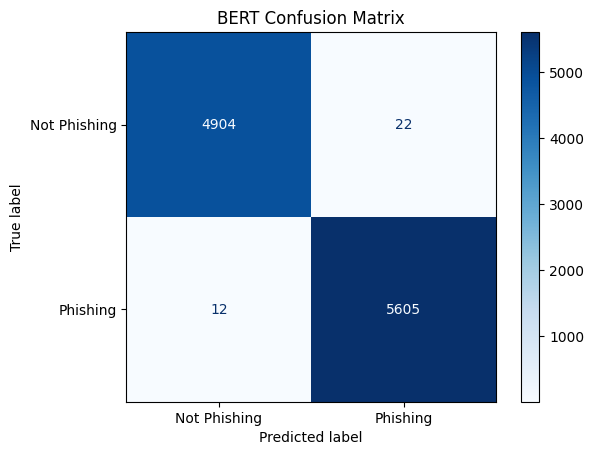

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_bert)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("BERT Confusion Matrix")
plt.grid(False)
plt.show()
